In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from spacy import displacy
import boto3
from tqdm.notebook import tqdm
import os
import numpy as np

/home/ec2-user/anaconda3/envs/sepsis_env/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/sepsis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize a session using boto3
s3 = boto3.client('s3')

# Define the S3 bucket and file details
bucket_name = 'aiforce-bucket'
s3_path = 's3://aiforce-bucket/'

admissions_file_name = 'ADMISSIONS.csv'
note_file_name = 'NOTEEVENTS.csv'
diag_file_name = 'DIAGNOSES_ICD.csv'
labevent_file_name = 'LABEVENTS.csv'
chartevent_file_name = 'CHARTEVENTS.csv'

admissions = pd.read_csv(s3_path + admissions_file_name)
# note_events = pd.read_csv(s3_path + note_file_name)
diagnoses_icd =pd.read_csv(s3_path + diag_file_name)
# labevents = pd.read_csv(s3_path + labevent_file_name)

In [3]:
# labevents.to_csv('LABEVENTS.csv', index=False)
note_events = pd.read_csv('NOTEEVENTS.csv')
labevents = pd.read_csv('LABEVENTS.csv')

/tmp/ipykernel_16349/2347179164.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  note_events = pd.read_csv('NOTEEVENTS.csv')


In [4]:
hf_vital_sign_dict = {
    220045: 'Heart Rate',
    220179: 'Non Invasive Blood Pressure systolic',
    220180: 'Non Invasive Blood Pressure diastolic',
    220210: 'Respiratory Rate',
    220277: 'O2 Saturation',
    223762: 'Glasgow Coma Scale',
    220181: 'Non Invasive Blood Pressure mean',
    220074: 'Temperature Celsius',
    220621: 'Glucose',
    223830: 'Arterial Blood Pressure mean',
    226559: 'Urine Output',
    223835: 'Glasgow Coma Scale verbal',
    223837: 'Glasgow Coma Scale eye opening'
}

# vital_sign_itemids = list(hf_vital_sign_dict.values())

# # Load in chunks
# chunk_size = 500000  # Adjust this size based on memory capacity
# chunks = pd.read_csv(s3_path + chartevent_file_name, chunksize=chunk_size)
# filtered_chunks = []
# # Iterate over chunks to process or filter data
# for chunk in chunks:
#     # Filter relevant rows in each chunk
#     chunk_filtered = chunk[chunk['ITEMID'].isin(list(hf_vital_sign_dict.keys()))]
    
#     # Append filtered chunk to the list
#     filtered_chunks.append(chunk_filtered)

# # Concatenate all filtered chunks into a single DataFrame
# chart_events = pd.concat(filtered_chunks, ignore_index=True)

In [5]:
# chart_events.to_csv('CHARTEVENTS - hf_filtered.csv', index=False)
chartevents = pd.read_csv('CHARTEVENTS - hf_filtered.csv')

/tmp/ipykernel_16349/1137669.py:2: DtypeWarning: Columns (8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents = pd.read_csv('CHARTEVENTS - hf_filtered.csv')


In [6]:
admissions.columns = [col.lower() for col in admissions.columns]
diagnoses_icd.columns = [col.lower() for col in diagnoses_icd.columns]
note_events.columns = [col.lower() for col in note_events.columns]
labevents.columns = [col.lower() for col in labevents.columns]
chartevents.columns = [col.lower() for col in chartevents.columns]

In [7]:
# Filter for heart failure ICD-9 codes (428.x)
heart_failure_icd_codes = ['4280', '4281', '42820', '42821', '42822', '42823', '42830', '42831', '42832', '42833']
heart_failure_patients = diagnoses_icd[diagnoses_icd['icd9_code'].isin(heart_failure_icd_codes)]

# Extract the hospital admission IDs (HADM_ID) for heart failure patients
heart_failure_patient_ids = heart_failure_patients['hadm_id'].unique()

In [8]:
# Check the first few rows of the datasets
print(note_events.head())
print(diagnoses_icd.head())

# View basic information about the datasets
print(note_events.info())
print(diagnoses_icd.info())


   row_id  subject_id   hadm_id   chartdate charttime storetime  \
0     174       22532  167853.0  2151-08-04       NaN       NaN   
1     175       13702  107527.0  2118-06-14       NaN       NaN   
2     176       13702  167118.0  2119-05-25       NaN       NaN   
3     177       13702  196489.0  2124-08-18       NaN       NaN   
4     178       26880  135453.0  2162-03-25       NaN       NaN   

            category description  cgid  iserror  \
0  Discharge summary      Report   NaN      NaN   
1  Discharge summary      Report   NaN      NaN   
2  Discharge summary      Report   NaN      NaN   
3  Discharge summary      Report   NaN      NaN   
4  Discharge summary      Report   NaN      NaN   

                                                text  
0  Admission Date:  [**2151-7-16**]       Dischar...  
1  Admission Date:  [**2118-6-2**]       Discharg...  
2  Admission Date:  [**2119-5-4**]              D...  
3  Admission Date:  [**2124-7-21**]              ...  
4  Admission Da

In [9]:
# Count missing values for each column
print(note_events.isnull().sum())
print(diagnoses_icd.isnull().sum())

row_id               0
subject_id           0
hadm_id         231836
chartdate            0
charttime       316566
storetime       836776
category             0
description          0
cgid            836776
iserror        2082294
text                 0
dtype: int64
row_id        0
subject_id    0
hadm_id       0
seq_num       0
icd9_code     0
dtype: int64


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistical summary of numeric columns
print(note_events.describe())

             row_id    subject_id       hadm_id          cgid  iserror
count  2.083180e+06  2.083180e+06  1.851344e+06  1.246404e+06    886.0
mean   1.041590e+06  3.242564e+04  1.498796e+05  1.771630e+04      1.0
std    6.013624e+05  2.755425e+04  2.878059e+04  2.158703e+03      0.0
min    1.000000e+00  2.000000e+00  1.000010e+05  1.401000e+04      1.0
25%    5.207958e+05  1.146500e+04  1.251950e+05  1.580300e+04      1.0
50%    1.041590e+06  2.344400e+04  1.496010e+05  1.759300e+04      1.0
75%    1.562385e+06  5.077200e+04  1.748120e+05  1.959900e+04      1.0
max    2.083180e+06  9.999900e+04  1.999990e+05  2.157000e+04      1.0


Heart Failure Cases: 1927 (0.09%)
Non-Heart Failure Cases: 2081253 (99.91%)


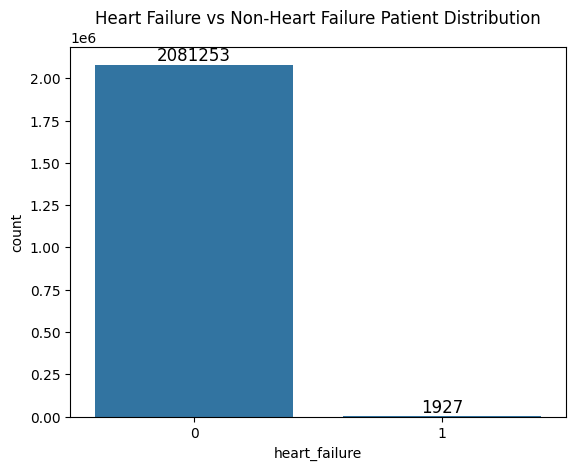

In [11]:
# Add heart failure labels (binary classification: 1 for heart failure, 0 for non-heart failure)
heart_failure_icd_codes = ['4280', '4281', '42820', '42821', '42822', '42823', '42830', '42831', '42832', '42833']
heart_failure_patients = diagnoses_icd[diagnoses_icd['icd9_code'].isin(heart_failure_icd_codes)]
heart_failure_patient_ids = heart_failure_patients['hadm_id'].unique()

# Label heart failure in the dataset
note_events['heart_failure'] = note_events['hadm_id'].apply(lambda x: 1 if x in heart_failure_patient_ids else 0)

# Calculate totals and percentages
heart_failure_totals = note_events['heart_failure'].value_counts()
heart_failure_percentages = note_events['heart_failure'].value_counts(normalize=True) * 100

# Print totals and percentages
print(f"Heart Failure Cases: {heart_failure_totals[1]} ({heart_failure_percentages[1]:.2f}%)")
print(f"Non-Heart Failure Cases: {heart_failure_totals[0]} ({heart_failure_percentages[0]:.2f}%)")

# Create the count plot
ax = sns.countplot(x='heart_failure', data=note_events)
plt.title('Heart Failure vs Non-Heart Failure Patient Distribution')

# Add the numbers on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=12)

plt.show()

In [12]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Loop through each vital sign column
# vital_sign_columns = ['heart_rate_mean', 'blood_pressure_mean', 'respiratory_rate_mean', 'temperature_mean']
# plt.figure(figsize=(14, 8))
# for i, col in enumerate(vital_sign_columns, 1):
#     plt.subplot(2, 2, i)
#     sns.histplot(data=chartevents_pivot, x=col, kde=True)
#     plt.title(f'Distribution of {col}')
# plt.tight_layout()
# plt.show()


In [13]:
"""ML process for predicting heart failure"""

'ML process for predicting heart failure'

In [14]:
# Step 1: Filter diagnoses icd table to get unique heart_failure related hadm_ids
heart_failure_icd_codes = ['4280', '4281', '42820', '42821', '42822', '42823', '42830', '42831', '42832', '42833']
heart_failure_patients = diagnoses_icd[diagnoses_icd['icd9_code'].isin(heart_failure_icd_codes)]
heart_failure_patient_ids = heart_failure_patients['hadm_id'].unique()

#also filtering admissions for relevant columns
admissions_relevant = admissions[['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'edregtime', 'edouttime']]

In [15]:
# Step 2: Vectorize clinical notes; only looking at first 10,000 cases AND all cases including heart_failure
# basic cleaning; filling nulls with empty strings and setting all to lower case
note_events['text_clean'] = note_events['text'].fillna('').str.lower()

# Create TF-IDF vectors from the clinical notes (for simplicity, we use the first 100,000 rows)
vectorizer = TfidfVectorizer(max_features=500)

hf_notes = note_events[note_events['hadm_id'].isin(heart_failure_patient_ids)]
X_hf_notes = vectorizer.fit_transform(hf_notes['text_clean'])
X_notes = vectorizer.fit_transform(note_events['text_clean'][:10000])  # Adjust number of rows as needed

X_hf_df = pd.DataFrame(X_hf_notes.toarray(), columns=vectorizer.get_feature_names_out())
X_hf_df['hadm_id'] = hf_notes['hadm_id'].values

# Reorder columns to have 'hadm_id' as the first column
X_hf_df = X_hf_df[['hadm_id'] + [col for col in X_hf_df.columns if col != 'hadm_id']]

X_notes_df = pd.DataFrame(X_notes.toarray(), columns=vectorizer.get_feature_names_out())
X_notes_df['hadm_id'] = note_events['hadm_id'][:10000].values

# Reorder columns to have 'hadm_id' as the first column
X_notes_df = X_notes_df[['hadm_id'] + [col for col in X_notes_df.columns if col != 'hadm_id']]

X_notes_df = pd.concat((X_notes_df, X_hf_df))
X_notes_df = X_notes_df.drop_duplicates('hadm_id')

In [16]:
# X_notes_df.to_csv('note_embeddings.csv', index=False)
# X_notes_df = pd.read_csv('note_embeddings.csv')
# X_notes_df = X_notes_df.drop('diagnosis', axis=1)

In [17]:
# Step 2.5: saving copies of dfs to avoid having to re-load
X_notes_df_temp = X_notes_df.copy()
chartevents_filtered = chartevents.copy()
labevents_filtered = labevents.copy()

In [18]:
# Step 3: Properly format chartevents and labevents to ensure each feature has its own column
chartevents_filtered['vital_sign'] = chartevents_filtered['itemid'].map(hf_vital_sign_dict)
# Pivot the filtered data to create a column for each vital sign
chartevents_pivot = chartevents_filtered.pivot_table(
    index='hadm_id',
    columns='vital_sign',
    values='valuenum',
    aggfunc='mean'
).reset_index()

# Rename columns if needed (e.g., heart rate and blood pressure)
chartevents_pivot.columns.name = None  # Remove index name for clarity
chartevents_pivot = chartevents_pivot.rename(columns={
    'Heart Rate': 'heart_rate_mean',
    'Blood Pressure': 'blood_pressure_mean'
})

# Aggregate lactate values separately
labevents_agg = labevents_filtered.groupby('hadm_id').agg({
    'valuenum': 'mean'
}).reset_index().rename({'valuenum': 'lactate_mean'}, axis=1)

# Merge the two DataFrames on 'hadm_id'
combined_df = pd.merge(chartevents_pivot, labevents_agg, on='hadm_id', how='outer')

In [19]:
# Step 4: Merge combined data (vitals, labs) with admissions table and notes
X_structured = pd.merge(admissions_relevant, combined_df, on='hadm_id', how='left')
X_structured = pd.merge(X_structured, X_notes_df_temp, on='hadm_id', how='right')

# Drop any irrelevant columns and handle missing values
X_structured = X_structured.drop(columns=['subject_id', 'admittime', 'dischtime'])  # Drop unwanted columns
X_structured.fillna(0, inplace=True)  # Handle missing data

In [20]:
# Step 5: Create label encoder instance
label_encoder = LabelEncoder()
# Apply label encoding to each categorical column
for column in ['admission_type', 'admission_location']:
    X_structured[column] = label_encoder.fit_transform(X_structured[column].astype(str))

In [21]:
# Step 6 Extract features from datetime columns
# Ensure that datetime columns are in the correct format
X_structured['deathtime'] = pd.to_datetime(X_structured['deathtime'], errors='coerce')
X_structured['edregtime'] = pd.to_datetime(X_structured['edregtime'], errors='coerce')
X_structured['edouttime'] = pd.to_datetime(X_structured['edouttime'], errors='coerce')

X_structured['deathtime_hour'] = X_structured['deathtime'].dt.hour
X_structured['deathtime_day'] = X_structured['deathtime'].dt.day
X_structured['deathtime_month'] = X_structured['deathtime'].dt.month
X_structured['deathtime_year'] = X_structured['deathtime'].dt.year

X_structured['edregtime_hour'] = X_structured['edregtime'].dt.hour
X_structured['edregtime_day'] = X_structured['edregtime'].dt.day
X_structured['edregtime_month'] = X_structured['edregtime'].dt.month
X_structured['edregtime_year'] = X_structured['edregtime'].dt.year

X_structured['edouttime_hour'] = X_structured['edouttime'].dt.hour
X_structured['edouttime_day'] = X_structured['edouttime'].dt.day
X_structured['edouttime_month'] = X_structured['edouttime'].dt.month
X_structured['edouttime_year'] = X_structured['edouttime'].dt.year

X_structured = X_structured.drop(['deathtime', 'edregtime', 'edouttime'], axis=1)

In [29]:
# Step 7: Split data into train and test sets
# Add heart failure label
X_structured['heart_failure'] = X_structured['hadm_id'].apply(lambda x: 1 if x in heart_failure_patient_ids else 0)

y = X_structured['heart_failure']
X_combined_for_tr = X_structured.drop(columns=['row_id', 'heart_failure', 'hadm_id', 'diagnosis'])  # Remove label and ID columns
X_train, X_test, y_train, y_test = train_test_split(X_combined_for_tr, y, test_size=0.2, random_state=42)

In [30]:
# Step 8: Train an XGBoost classifier
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
# Step 9: Evaluate the model
y_pred = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')
print(classification_report(y_test, y_pred))

ROC AUC: 0.85
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1878
           1       1.00      0.70      0.82        10

    accuracy                           1.00      1888
   macro avg       1.00      0.85      0.91      1888
weighted avg       1.00      1.00      1.00      1888



In [37]:
# # Step 10: Re-run training using undersampling technique of the majority class
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Apply random undersampling to balance the classes
undersampler = RandomUnderSampler(random_state=42, sampling_strategy=1)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

# Train/test split on the resampled data
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Train the XGBoost model on the resampled dataset
model = XGBClassifier()
model.fit(X_train_under, y_train_under)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [38]:
# Step 11: Evaluate the model
y_pred = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')
print(classification_report(y_test, y_pred))

ROC AUC: 0.9279020234291799
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1878
           1       0.10      0.90      0.18        10

    accuracy                           0.96      1888
   macro avg       0.55      0.93      0.58      1888
weighted avg       0.99      0.96      0.97      1888



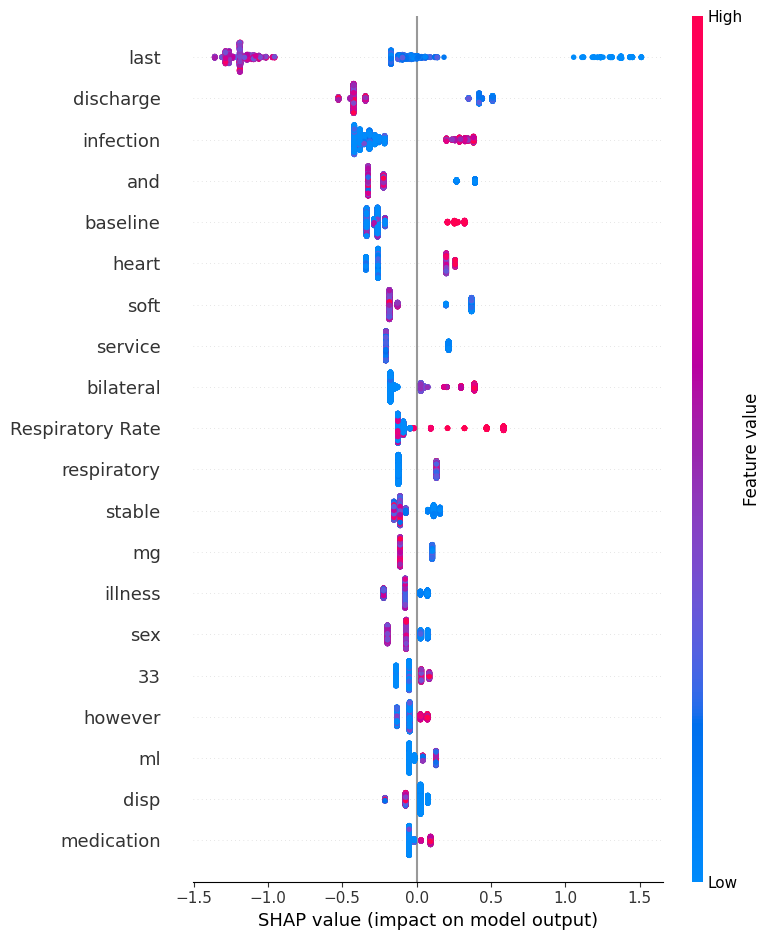

In [27]:
# Step 12: Model interpretability with SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize SHAP values for feature importance
shap.summary_plot(shap_values, X_test)